# Introducción y Análisis

In [1]:
# Librerias
import numpy as np
import keras
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, Embedding, Flatten
from keras.models import Sequential
from keras.layers import Flatten
import keras_tuner
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, auc, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, label_binarize



Se leen los datos del .csv

In [2]:
#Inicializar y abrir archivo
corpus=[]
dic_diag={}
dic_proc={}
dic_grd={}
archivo=open("dataset_elpino.csv",encoding="utf-8")

#Sacar las variables (features o característica)
header=archivo.readline().strip().split(";")
features=[]
for col in header:
    if col.startswith("Diag") or col.startswith("Proc"):
        col=col.split(" ")
        col=col[0]+col[1]
    features.append(col)

#Sacar la data (deja sólo los códigos en el corpus y en diccionario las descripciones)
for linea in archivo:
    row=[]
    linea=linea.strip().split(";")
    for i in range(len(linea)):
        cod=linea[i].split("-")[0].strip()
        if len(linea[i].split("-")) == 2:
            des=linea[i].split("-")[1].strip()
        if i < 35:
            dic_diag[cod]=des
        elif i < 65:
            dic_proc[cod]=des
        elif i == 67:
            dic_grd[cod]=des
        elif i==66:
            cod = 1 if cod=="Mujer" else 0
        row.append(cod)
    corpus.append(row)

#Crear un dataframe con la data
df = pd.DataFrame(corpus, columns=features)
df.head(20)

,Diag01,Diag02,Diag03,Diag04,Diag05,Diag06,Diag07,Diag08,Diag09,Diag10,...,Proced24,Proced25,Proced26,Proced27,Proced28,Proced29,Proced30,Edad en años,Sexo (Desc),GRD
0,A41.8,B37.6,I39.8,N10,B96.1,L89.9,L08.9,B96.2,A41.5,J86.9,...,99.84,88.72,90.42,90.52,91.39,91.33,87.03,40,0,184103
1,U07.1,J12.8,R06.0,R05,R50.9,Z29.0,Z01.7,J96.00,J94.2,J92.9,...,91.62,90.43,91.39,90.52,91.32,96.59,90.99,53,0,041013
2,K56.5,R57.2,R57.1,J80,Y95,J15.0,U82.2,B95.6,B96.8,B37.1,...,99.84,91.73,90.53,99.26,89.39,89.66,89.65,65,0,041013
3,K76.8,K66.1,N18.5,D64.9,E87.5,E87.2,J81,N17.8,J44.9,R41.0,...,57.94,00.13,00.17,99.04,99.18,99.21,99.23,61,0,041023
4,T81.0,Y83.2,S31.1,S36.80,W31.62,J96.09,J15.0,U82.2,U07.1,N39.0,...,90.52,91.39,91.32,93.90,99.15,96.59,45.13,30,0,041023
5,U07.1,J12.8,R06.0,R50.9,R53,R05,Z29.0,Z01.7,J96.00,J80,...,57.94,00.17,89.39,96.6,99.26,91.82,90.99,49,1,041013
6,U07.1,J12.8,R06.0,R05,Z29.0,Z01.7,J96.09,J80,J15.1,A41.8,...,91.32,99.18,93.94,99.21,00.17,99.29,99.19,55,0,041013
7,U07.1,J12.8,J96.09,J80,R06.0,R50.9,R05,M79.19,Z29.0,Z01.7,...,99.17,99.18,99.19,99.21,99.23,99.26,99.29,33,1,041013
8,U07.1,J12.8,J80,Z20.8,Z29.0,Z01.7,T81.4,Y83.6,K85.9,K65.0,...,99.04,99.18,99.19,99.21,99.26,99.29,93.01,37,1,041023
9,U07.1,J12.8,J96.00,R50.9,R11,R05,M79.19,R07.0,A09.9,Z29.0,...,99.26,99.29,93.01,93.09,93.11,93.12,93.13,59,0,041023


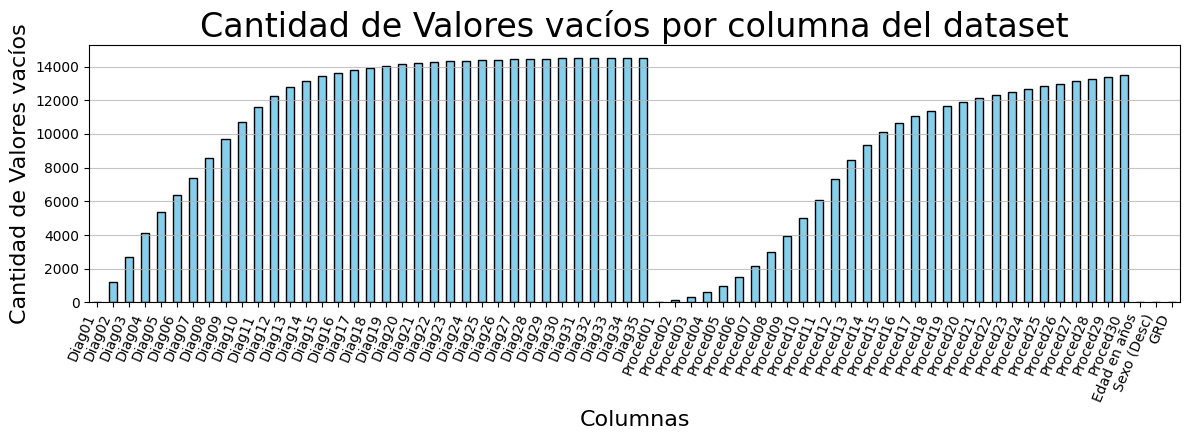

In [3]:
# Calcular la cantidad de valores '' en las primeras 65 columnas
valores_vacios_str = (df.iloc[:, :] == '').sum()

# Crear el gráfico de barras
plt.figure(figsize=(12, 4.5))
valores_vacios_str.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cantidad de Valores vacíos por columna del dataset', fontsize=24)
plt.xticks(rotation=22.5+45, ha='right')
plt.xlabel('Columnas', fontsize=16)
plt.ylabel('Cantidad de Valores vacíos', fontsize=16)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

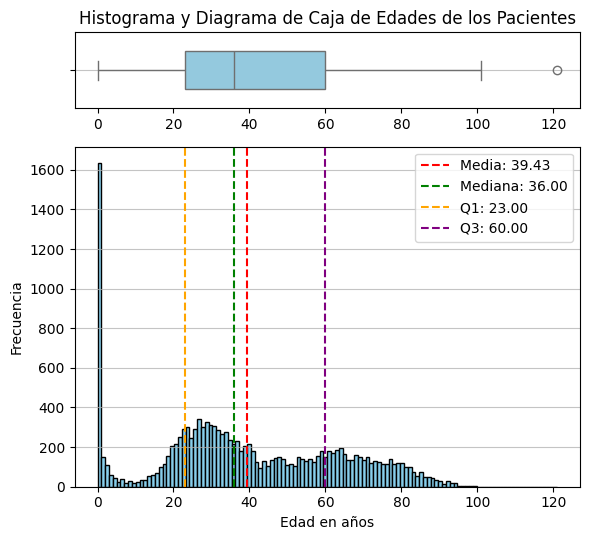

In [4]:
# Calcular estadísticas
q1 = df['Edad en años'].astype(int).quantile(0.25)
q3 = df['Edad en años'].astype(int).quantile(0.75)
iqr = q3 - q1
media = df['Edad en años'].astype(int).mean()
mediana = df['Edad en años'].astype(int).median()

# Crear una figura con subgráficos
fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 4.5]}, figsize=(6, 5.5))

# Diagrama de caja
sns.boxplot(x=df['Edad en años'].astype(int), showfliers=True, color='skyblue', ax=axes[0], width=0.5)
axes[0].set_title('Histograma y Diagrama de Caja de Edades de los Pacientes')
axes[0].grid(axis='y', alpha=0.75)
axes[0].set_xlabel('')

# Histograma
axes[1].hist([int(i) for i in df['Edad en años']], bins=120, color='skyblue', edgecolor='black')
axes[1].axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
axes[1].axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.2f}')
axes[1].axvline(q1, color='orange', linestyle='--', label=f'Q1: {q1:.2f}')
axes[1].axvline(q3, color='purple', linestyle='--', label=f'Q3: {q3:.2f}')
axes[1]
axes[1].set_xlabel('Edad en años')
axes[1].set_ylabel('Frecuencia')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.75)

# Ajustar el diseño
plt.tight_layout()
plt.show()

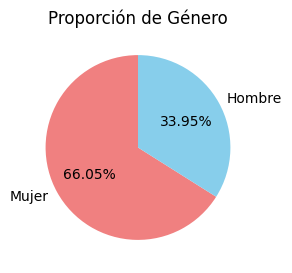

In [5]:
# Calcular la proporción de género
proporcion_genero = df['Sexo (Desc)'].value_counts(normalize=True) * 100

# Crear un gráfico de torta para la proporción de género
plt.figure(figsize=(3,3))
proporcion_genero.index = ['Mujer', 'Hombre']  # Cambiar las etiquetas
proporcion_genero.plot(kind='pie', autopct='%1.2f%%', colors=['lightcoral', 'skyblue'], startangle=90)
plt.title('Proporción de Género')
plt.ylabel('')  # Eliminar la etiqueta del eje Y
plt.show()


In [ ]:
# Contar la cantidad de instancias por clase en la columna GRD
cantidad_por_clase = df['GRD'].value_counts()

# Calcular el porcentaje acumulado de instancias por clase
clases_acumulado = cantidad_por_clase.cumsum()

# Encontrar el número de clases necesarias para acumular el 80% de las instancias
clases_80 = (clases_acumulado  / cantidad_por_clase.sum() <= 0.8).sum()

# Crear el gráfico acumulativo
plt.figure(figsize=(7.5, 3))
plt.plot(clases_acumulado.values, color='skyblue')
plt.axhline(clases_acumulado[clases_80], color='red', linestyle='--', label='80% de las instancias')
plt.axvline(clases_80, color='green', linestyle='--', label=f'{100*clases_80/len(cantidad_por_clase):.2f}% de las clases')
plt.title('Frecuencia Acumulada de Instancias por Clase')
plt.xlabel('Índice de Clase')
plt.ylabel('Frecuencia Acumulada')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [7]:
# Filtrar las clases con al menos 5 instancias
clases_con_suficientes_instancias = df['GRD'].value_counts()[df['GRD'].value_counts() >= 5].index
df = df[df['GRD'].isin(clases_con_suficientes_instancias)]

In [8]:
# Crear los grupos etáreos
df['Grupo Etáreo'] = pd.qcut(df['Edad en años'].astype(int), q=10, labels=[f'Grupo {i+1}' for i in range(10)])
for i in df['Grupo Etáreo'].value_counts().keys():
    print(i, df['Grupo Etáreo'].value_counts()[i]/len(df)*100)
df = df.drop(columns=['Edad en años'], axis=1)

Grupo 1 11.439688715953308
Grupo 3 11.107180756986205
Grupo 7 10.640254686947294
Grupo 6 9.982313406437921
Grupo 8 9.975238769013089
Grupo 10 9.663954722320481
Grupo 5 9.557835160948
Grupo 9 9.508312698974178
Grupo 2 9.168730102582243
Grupo 4 8.956490979837284


# Otros modelos

In [17]:
df.iloc[0]

Diag01            A41.8
Diag02            B37.6
Diag03            I39.8
Diag04              N10
Diag05            B96.1
                 ...   
Proced29          91.33
Proced30          87.03
Sexo (Desc)           0
GRD              184103
Grupo Etáreo    Grupo 6
Name: 0, Length: 68, dtype: object

In [11]:
for column in df.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

X = df.drop(columns=['GRD'])
y = df['GRD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Regresión Logística

In [ ]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

for solver in solvers:
    print("\nEntrenando modelo de Regresión Logística con solver", solver)
    logistic_model = LogisticRegression(
        max_iter=10, # Sólo 10 iteraciones porque con 100 estuvo más de una hora y no dio :/
        random_state=42,
        solver=solver
    )
    logistic_model.fit(X_train, y_train)
    y_pred_logistic = logistic_model.predict(X_test)
    print("Resultados de Regresión Logística:")
    print("     Accuracy:", accuracy_score(y_test, y_pred_logistic))
    print('     Precision:', precision_score(y_test, y_pred_logistic, average='weighted'))
    print('     Recall:', recall_score(y_test, y_pred_logistic, average='weighted'))
    print('     F1 Score:', f1_score(y_test, y_pred_logistic, average='weighted'))

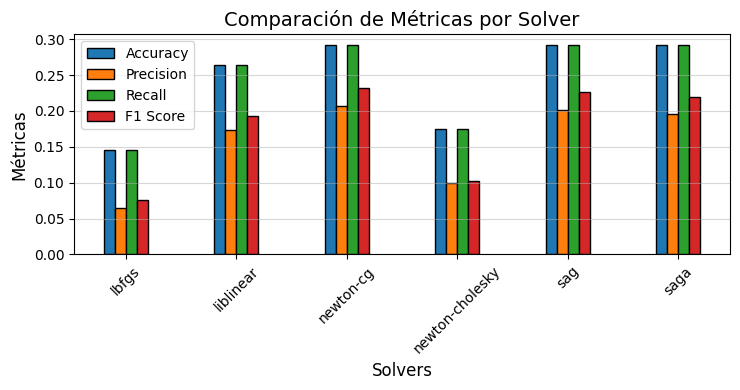

Máximos de Logistic Regression:
     Accuracy:  0.2922
     Precision: 0.2074
     Recall:    0.2922
     F1 Score:  0.2318


In [58]:
# Se ingresan manualmente los resultados de los modelos aquí por falta de tiempo, disculpas :/
accuracies = [0.14609126282278034,0.26353024407499115,0.2921825256455607,0.17474354439334985,0.2918287937743191,0.2918287937743191]
precisions = [0.06412400244874028,0.1740719611402245,0.20741501995725517,0.09975526028754823,0.20113981741556664,0.19585371236118773]
recalls = [0.14609126282278034,0.26353024407499115,0.2921825256455607,0.17474354439334985,0.2918287937743191,0.2918287937743191]
f1_scores = [0.07593218173044855,0.19321956207454585,0.2318244500684546,0.10302636562228128,0.22658267163396903,0.219509092833085]

x = np.arange(len(solvers))
width = 0.1

plt.figure(figsize=(7.5, 4))
plt.bar(x - 1.5 * width, accuracies, width, label='Accuracy', edgecolor='black')
plt.bar(x - 0.5 * width, precisions, width, label='Precision', edgecolor='black')
plt.bar(x + 0.5 * width, recalls, width, label='Recall', edgecolor='black')
plt.bar(x + 1.5 * width, f1_scores, width, label='F1 Score', edgecolor='black')

plt.xticks(x, solvers, rotation=45)
plt.xlabel('Solvers', fontsize=12)
plt.ylabel('Métricas', fontsize=12)
plt.title('Comparación de Métricas por Solver', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

maximos = [max(accuracies), precisions[accuracies.index(max(accuracies))], recalls[accuracies.index(max(accuracies))], f1_scores[accuracies.index(max(accuracies))]]
print("Máximos de Logistic Regression:")
print("     Accuracy: ", round(maximos[0],4))
print("     Precision:", round(maximos[1],4))
print("     Recall:   ", round(maximos[2],4))
print("     F1 Score: ", round(maximos[3],4))

## Arbol de Decisión

In [ ]:
depths = list(range(1, 31))
accuracies = []
precisions = []
recalls = []
f1_scores = []

for i in depths:
    decision_tree_model = DecisionTreeClassifier(random_state=42, max_depth=i)
    decision_tree_model.fit(X_train, y_train)
    y_pred_tree = decision_tree_model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred_tree))
    precisions.append(precision_score(y_test, y_pred_tree, average='weighted', zero_division=0))
    recalls.append(recall_score(y_test, y_pred_tree, average='weighted', zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred_tree, average='weighted', zero_division=0))

Máximos de Decision Tree: [0.5843650512911214, 0.5801356719281917, 0.5843650512911214, 0.5716496211645832]


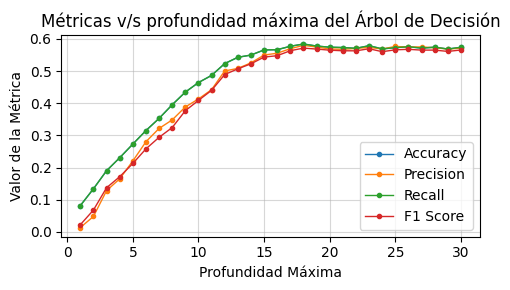

Máximos de Decision Tree:
     Accuracy:  0.5844
     Precision: 0.5801
     Recall:    0.5844
     F1 Score:  0.5716


In [55]:
plt.figure(figsize=(5, 3))
plt.plot(depths, accuracies, label='Accuracy', marker='o', ms=3, lw=1)
plt.plot(depths, precisions, label='Precision', marker='o', ms=3, lw=1)
plt.plot(depths, recalls, label='Recall', marker='o', ms=3, lw=1)
plt.plot(depths, f1_scores, label='F1 Score', marker='o', ms=3, lw=1)

plt.title('Métricas v/s profundidad máxima del Árbol de Decisión')
plt.xlabel('Profundidad Máxima')
plt.ylabel('Valor de la Métrica')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

maximos = [max(accuracies), precisions[accuracies.index(max(accuracies))], recalls[accuracies.index(max(accuracies))], f1_scores[accuracies.index(max(accuracies))]]
print("Máximos de Decision Tree:")
print("     Accuracy: ", round(maximos[0],4))
print("     Precision:", round(maximos[1],4))
print("     Recall:   ", round(maximos[2],4))
print("     F1 Score: ", round(maximos[3],4))

## Random Forest

In [56]:
estimators = list(range(10, 110, 10))
accuracies = []
precisions = []
recalls = []
f1_scores = []

for i in estimators:
    print("\nEntrenando modelo de Random Forest con", i, "estimadores")
    random_forest_model = RandomForestClassifier(n_estimators=i, random_state=42, max_depth=18)
    random_forest_model.fit(X_train, y_train)
    y_pred_forest = random_forest_model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred_forest))
    precisions.append(precision_score(y_test, y_pred_forest, average='weighted', zero_division=0))
    recalls.append(recall_score(y_test, y_pred_forest, average='weighted', zero_division=0))
    f1_scores.append(f1_score(y_test, y_pred_forest, average='weighted', zero_division=0))


Entrenando modelo de Random Forest con 10 estimadores

Entrenando modelo de Random Forest con 20 estimadores

Entrenando modelo de Random Forest con 30 estimadores

Entrenando modelo de Random Forest con 40 estimadores

Entrenando modelo de Random Forest con 50 estimadores

Entrenando modelo de Random Forest con 60 estimadores

Entrenando modelo de Random Forest con 70 estimadores

Entrenando modelo de Random Forest con 80 estimadores

Entrenando modelo de Random Forest con 90 estimadores

Entrenando modelo de Random Forest con 100 estimadores


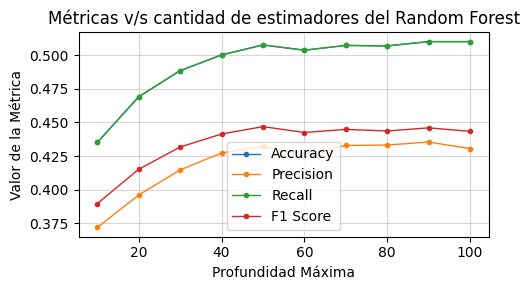

Máximos de Random Forest:
     Accuracy:  0.5101
     Precision: 0.4354
     Recall:    0.5101
     F1 Score:  0.446


In [57]:
plt.figure(figsize=(5, 3))
plt.plot(estimators, accuracies, label='Accuracy', marker='o', ms=3, lw=1)
plt.plot(estimators, precisions, label='Precision', marker='o', ms=3, lw=1)
plt.plot(estimators, recalls, label='Recall', marker='o', ms=3, lw=1)
plt.plot(estimators, f1_scores, label='F1 Score', marker='o', ms=3, lw=1)

plt.title('Métricas v/s cantidad de estimadores del Random Forest')
plt.xlabel('Profundidad Máxima')
plt.ylabel('Valor de la Métrica')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

maximos = [max(accuracies), precisions[accuracies.index(max(accuracies))], recalls[accuracies.index(max(accuracies))], f1_scores[accuracies.index(max(accuracies))]]
print("Máximos de Random Forest:")
print("     Accuracy: ", round(maximos[0],4))
print("     Precision:", round(maximos[1],4))
print("     Recall:   ", round(maximos[2],4))
print("     F1 Score: ", round(maximos[3],4))

## Redes Neuronales

In [15]:
seed = 12122008
X = []
Y = []

le = LabelEncoder()
for column in df.columns[:-1]:
    df[column] = le.fit_transform(df[column].astype(str))
X = df.iloc[:, :-1].values

ohe = OneHotEncoder(sparse_output=False)
Y = ohe.fit_transform(df['GRD'].values.reshape(-1, 1))

In [51]:
Y.shape

(14135, 327)

In [10]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify=Y)

### Sin Embedding

In [11]:
modelo=Sequential()
modelo.add(Input(shape=(X.shape[1],)))
modelo.add(Dense(32))
modelo.add(Dense(Y.shape[1],activation="softmax"))
modelo.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["acc"])
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 327)            │        10,791 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,967 (50.65 KB)

 Trainable params: 12,967 (50.65 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def build_model(hp):
    modelo = Sequential()
    modelo.add(Input(shape=(X.shape[1],)))
    for i in range(hp.Choice("capas", [1, 2, 3])):
        modelo.add(Dense(hp.Choice("neuronas_capa", [8, 16, 32, 64]), activation="relu"))
    modelo.add(Dense(y_train.shape[1], activation="softmax"))
    modelo.compile(
        loss="categorical_crossentropy",
        metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")],
        optimizer="adam"
    )
    return modelo

tuner=keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_acc",direction="max"),
    max_trials=16,
    executions_per_trial=1,
    overwrite=True,
    directory="modelos",
    project_name="GRD"
)

In [13]:
tuner.search(x_train,y_train,epochs=16,validation_data=(x_val,y_val),batch_size=32,verbose=1)

Trial 12 Complete [00h 00m 14s]
val_acc: 0.20304208993911743

Best val_acc So Far: 0.28298550844192505
Total elapsed time: 00h 02m 48s


In [14]:
mejor_modelo=tuner.get_best_models()[0]
mejor_modelo.summary()

c:\Users\bobaz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 327)            │        10,791 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,079 (58.90 KB)

 Trainable params: 15,079 (58.90 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
y_pred_probs=mejor_modelo.predict(x_val)

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
# Para multiclase, selecciona la clase con la mayor probabilidad
y_pred = np.argmax(y_pred_probs, axis=1)
y_val_classes = np.argmax(y_val, axis=1)  # Convertir one-hot encoding a clases

print(y_pred)

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

roc_aucs = []

# # Matriz de confusión
# matriz = confusion_matrix(y_val_classes, y_pred)
# ax = axes[0]
# sns.heatmap(matriz, annot=True, ax=ax, cmap="Blues", fmt="d")
# ax.set_title("Rec=" + str(round(recall_score(y_val_classes, y_pred, average='macro'), 2)) +
#              " Acc=" + str(round(accuracy_score(y_val_classes, y_pred), 2)) +
#              " Pre=" + str(round(precision_score(y_val_classes, y_pred, average='macro'), 2)))
# axes[0].set_xlabel('Predicted')
# axes[0].set_ylabel('Real')

# ROC Curve (requiere binarización para multiclase)
y_val_binarized = label_binarize(y_val_classes, classes=range(len(np.unique(y_val_classes))))
fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_val_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve para cada clase
for i in range(len(roc_auc)):
    axes[0].plot(fpr[i], tpr[i])#, label=f'Class {i} (area = {roc_auc[i]:0.2f})')
axes[0].plot([0, 1], [0, 1], '--', label='No Skill')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()

# Precision-Recall Curve
lr_precision = {}
lr_recall = {}
pr_auc = {}
for i in range(y_val_binarized.shape[1]):
    lr_precision[i], lr_recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_pred_probs[:, i])
    pr_auc[i] = auc(lr_recall[i], lr_precision[i])

# Plot Precision-Recall Curve para cada clase
for i in range(len(pr_auc)):
    axes[1].plot(lr_recall[i], lr_precision[i], marker='.')#, label=f'Class {i} (area = {pr_auc[i]:0.2f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('PR-RC Curve')
axes[1].legend()

print("Rec=" + str(round(recall_score(y_val_classes, y_pred, average='macro'), 2)) +
              " Acc=" + str(round(accuracy_score(y_val_classes, y_pred), 2)) +
              " Pre=" + str(round(precision_score(y_val_classes, y_pred, average='macro'), 2)))


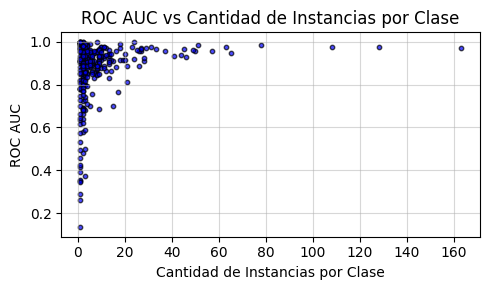

In [26]:
# Calcular la cantidad de instancias por clase
cantidad_instancias = np.sum(y_val_binarized, axis=0)

# Extraer los valores de roc_auc
roc_values = list(roc_auc.values())

# Crear el gráfico
plt.figure(figsize=(5, 3))
plt.scatter(cantidad_instancias, roc_values, color='blue', alpha=0.7, edgecolor='black', s=10)
plt.title('ROC AUC vs Cantidad de Instancias por Clase')
plt.xlabel('Cantidad de Instancias por Clase')
plt.ylabel('ROC AUC')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

El mejor modelo neuronal es el que tiene 3 capas ocultas de 32 neuronas

X_variable.shape: (14135, 1)
Y.shape: (14135, 327)
X_variable.shape: (14135, 2)
Y.shape: (14135, 327)
X_variable.shape: (14135, 3)
Y.shape: (14135, 327)
X_variable.shape: (14135, 4)
Y.shape: (14135, 327)
X_variable.shape: (14135, 5)
Y.shape: (14135, 327)
X_variable.shape: (14135, 6)
Y.shape: (14135, 327)
X_variable.shape: (14135, 7)
Y.shape: (14135, 327)
X_variable.shape: (14135, 8)
Y.shape: (14135, 327)
X_variable.shape: (14135, 9)
Y.shape: (14135, 327)
X_variable.shape: (14135, 10)
Y.shape: (14135, 327)
X_variable.shape: (14135, 11)
Y.shape: (14135, 327)
X_variable.shape: (14135, 12)
Y.shape: (14135, 327)
X_variable.shape: (14135, 13)
Y.shape: (14135, 327)
X_variable.shape: (14135, 14)
Y.shape: (14135, 327)
X_variable.shape: (14135, 15)
Y.shape: (14135, 327)
X_variable.shape: (14135, 16)
Y.shape: (14135, 327)
X_variable.shape: (14135, 17)
Y.shape: (14135, 327)
X_variable.shape: (14135, 18)
Y.shape: (14135, 327)
X_variable.shape: (14135, 19)
Y.shape: (14135, 327)
X_variable.shape: (14

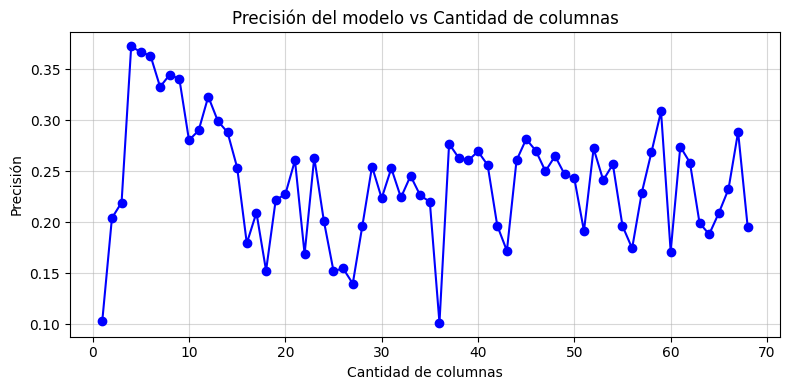

In [39]:
# Obtener las columnas sin valores vacíos
columnas_sin_vacios = valores_vacios_str[valores_vacios_str == 0].index.tolist()

# Ordenar las columnas restantes por cantidad de valores vacíos
columnas_con_vacios = valores_vacios_str[valores_vacios_str > 0].sort_values().index.tolist()

# Combinar las columnas en el orden deseado
columnas_ordenadas = columnas_sin_vacios + columnas_con_vacios

# Evaluar el modelo con diferentes cantidades de columnas
resultados = []
for i in range(1, len(columnas_ordenadas) + 1):
    columnas_seleccionadas = columnas_ordenadas[:i]
    # Encode categorical data into numeric values
    X_variable = df[columnas_seleccionadas].apply(LabelEncoder().fit_transform).values
    print('X_variable.shape:', X_variable.shape)
    print('Y.shape:', Y.shape)

    # Dividir los datos en entrenamiento y validación
    x_train_var, x_val_var, y_train_var, y_val_var = train_test_split(
        X_variable, Y, test_size=0.2, random_state=seed, stratify=Y
    )

    # Crear y entrenar el modelo
    modelo = Sequential()
    modelo.add(Input(shape=(x_train_var.shape[1],)))
    modelo.add(Dense(32, activation="relu"))
    modelo.add(Dense(32, activation="relu"))
    modelo.add(Dense(32, activation="relu"))
    modelo.add(Dense(Y.shape[1], activation="softmax"))
    modelo.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    modelo.fit(x_train_var, y_train_var, epochs=10, batch_size=32, verbose=0)

    # Evaluar el modelo
    loss, accuracy = modelo.evaluate(x_val_var, y_val_var, verbose=0)
    resultados.append({"columnas": i, "accuracy": accuracy})

# Mostrar los resultados
resultados_df = pd.DataFrame(resultados)
print(resultados_df)

# Graficar los resultados
plt.figure(figsize=(8, 4))
plt.plot(resultados_df["columnas"], resultados_df["accuracy"], marker="o", color="blue")
plt.title("Precisión del modelo vs Cantidad de columnas")
plt.xlabel("Cantidad de columnas")
plt.ylabel("Precisión")
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

### Ahora con Embedding

In [16]:
# Obtener las columnas sin valores vacíos
columnas_sin_vacios = valores_vacios_str[valores_vacios_str == 0].index.tolist()

# Ordenar las columnas restantes por cantidad de valores vacíos
columnas_con_vacios = valores_vacios_str[valores_vacios_str > 0].sort_values().index.tolist()

# Combinar las columnas en el orden deseado
columnas_ordenadas = columnas_sin_vacios + columnas_con_vacios

# Seleccionar las primeras 5 columnas ordenadas
X_optimo = df[columnas_ordenadas[:5]]  # Mantener los datos como están
print(X_optimo)

# Codificar las columnas seleccionadas con LabelEncoder
X_optimo_encoded = X_optimo.apply(LabelEncoder().fit_transform)
X_optimo_encoded = np.asarray(X_optimo_encoded)
Y = np.asarray(Y)

print("X_optimo_encoded shape:", X_optimo_encoded.shape)
print("Y shape:", Y.shape)
# Definir el vocabulario como el número de valores únicos en X_optimo_encoded
vocabulary = len(np.unique(X_optimo_encoded))
print("Vocabulario:", vocabulary)

       Diag01  Proced01  Sexo (Desc)  GRD Grupo Etáreo
0          22       347            0  287      Grupo 6
1        1324        22            0   27      Grupo 7
2         554       345            0   27      Grupo 9
3         601       180            0   28      Grupo 8
4        1302       178            0   28      Grupo 4
...       ...       ...          ...  ...          ...
14555     646       400            0  178      Grupo 7
14556     167       370            1  187      Grupo 3
14557    1138       362            0   15      Grupo 2
14558     635       412            0  131      Grupo 8
14560    1130       458            0   31      Grupo 9

[14135 rows x 5 columns]
X_optimo_encoded shape: (14135, 5)
Y shape: (14135, 327)
Vocabulario: 1364


In [17]:
X_optimo_encoded

array([[  22,  347,    0,  287,    6],
       [1324,   22,    0,   27,    7],
       [ 554,  345,    0,   27,    9],
       ...,
       [1138,  362,    0,   15,    2],
       [ 635,  412,    0,  131,    8],
       [1130,  458,    0,   31,    9]])

In [18]:
modelo = Sequential()
modelo.add(Embedding(input_dim=vocabulary, output_dim=64))  # Capa de Embedding
modelo.add(Flatten())  # Aplana la salida para que sea bidimensional
modelo.add(Dense(32, activation="relu"))  # Capa oculta
modelo.add(Dense(32, activation="relu"))  # Capa oculta
modelo.add(Dense(32, activation="relu"))  # Capa oculta
modelo.add(Dense(Y.shape[1], activation="softmax"))  # Capa de salida
modelo.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Hay que eliminar las clases que tienen menos de 5 elementos

In [76]:
x_train, x_val, y_train, y_val = train_test_split(X_optimo_encoded, Y, test_size=0.2, stratify=Y, random_state=seed)
modelo.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["acc"])
spam_emb = modelo.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=32, epochs=16,verbose=2,)

Epoch 1/16
354/354 - 3s - 8ms/step - acc: 0.3511 - loss: 3.3527 - val_acc: 0.7312 - val_loss: 1.4350
Epoch 2/16
354/354 - 1s - 3ms/step - acc: 0.8376 - loss: 0.8671 - val_acc: 0.9087 - val_loss: 0.4445
Epoch 3/16
354/354 - 1s - 4ms/step - acc: 0.9362 - loss: 0.2889 - val_acc: 0.9629 - val_loss: 0.1616
Epoch 4/16
354/354 - 1s - 3ms/step - acc: 0.9774 - loss: 0.0977 - val_acc: 0.9880 - val_loss: 0.0540
Epoch 5/16
354/354 - 1s - 3ms/step - acc: 0.9900 - loss: 0.0386 - val_acc: 0.9933 - val_loss: 0.0304
Epoch 6/16
354/354 - 1s - 3ms/step - acc: 0.9977 - loss: 0.0134 - val_acc: 0.9989 - val_loss: 0.0095
Epoch 7/16
354/354 - 1s - 3ms/step - acc: 0.9997 - loss: 0.0044 - val_acc: 1.0000 - val_loss: 0.0048
Epoch 8/16
354/354 - 1s - 3ms/step - acc: 0.9999 - loss: 0.0017 - val_acc: 1.0000 - val_loss: 0.0029
Epoch 9/16
354/354 - 1s - 3ms/step - acc: 1.0000 - loss: 8.7532e-04 - val_acc: 1.0000 - val_loss: 0.0021
Epoch 10/16
354/354 - 1s - 3ms/step - acc: 1.0000 - loss: 5.6855e-04 - val_acc: 1.0000 

In [77]:
def build_model(hp):
    modelo = Sequential()
    modelo.add(Embedding(input_dim=vocabulary, output_dim=hp.Choice("capas", [8, 16, 32, 64, 128])))  # Capa de Embedding
    modelo.add(Flatten())  # Aplana la salida para que sea bidimensional
    modelo.add(Dense(32, activation="relu"))  # Capa oculta
    modelo.add(Dense(32, activation="relu"))  # Capa oculta
    modelo.add(Dense(32, activation="relu"))  # Capa oculta
    modelo.add(Dense(Y.shape[1], activation="softmax"))  # Capa de salida
    modelo.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return modelo

(11228, 5)

In [81]:
tuner=keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_accuracy",direction="max"),
    max_trials=32,
    executions_per_trial=1,
    overwrite=True,
    directory="modelos",
    project_name="reprobacion"
)

In [82]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
capas (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64, 128], 'ordered': True}


In [66]:
len(y_train[0])

327

In [83]:
tuner.search(x_train,y_train,epochs=8,validation_data=(x_val,y_val),batch_size=32,verbose=1)

Trial 5 Complete [00h 00m 17s]
val_accuracy: 0.9996462464332581

Best val_accuracy So Far: 0.9996462464332581
Total elapsed time: 00h 01m 14s


In [ ]:
mejor_modelo=tuner.get_best_models()[0]
mejor_modelo.summary()

In [85]:
y_pred_probs=mejor_modelo.predict(x_val)

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [88]:
x_val[0]

array([1257,  362,    1,  313,    6])

In [87]:
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=np.argmax(y_val,axis=1)
sum(y_pred == y_true) / len(y_pred) * 100

np.float64(99.96462681287585)

In [53]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

import seaborn as sns
from sklearn.preprocessing import label_binarize

In [89]:
# Para multiclase, selecciona la clase con la mayor probabilidad
y_pred = np.argmax(y_pred_probs, axis=1)
y_val_classes = np.argmax(y_val, axis=1)  # Convertir one-hot encoding a clases

sum(y_pred == y_val_classes)

np.int64(2826)

In [ ]:
# Para multiclase, selecciona la clase con la mayor probabilidad
y_pred = np.argmax(y_pred_probs, axis=1)
y_val_classes = np.argmax(y_val, axis=1)  # Convertir one-hot encoding a clases

print(y_pred)

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

roc_aucs = []

# # Matriz de confusión
# matriz = confusion_matrix(y_val_classes, y_pred)
# ax = axes[0]
# sns.heatmap(matriz, annot=True, ax=ax, cmap="Blues", fmt="d")
# ax.set_title("Rec=" + str(round(recall_score(y_val_classes, y_pred, average='macro'), 2)) +
#              " Acc=" + str(round(accuracy_score(y_val_classes, y_pred), 2)) +
#              " Pre=" + str(round(precision_score(y_val_classes, y_pred, average='macro'), 2)))
# axes[0].set_xlabel('Predicted')
# axes[0].set_ylabel('Real')

# ROC Curve (requiere binarización para multiclase)
y_val_binarized = label_binarize(y_val_classes, classes=range(len(np.unique(y_val_classes))))
fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_val_binarized.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve para cada clase
for i in range(len(roc_auc)):
    axes[0].plot(fpr[i], tpr[i])#, label=f'Class {i} (area = {roc_auc[i]:0.2f})')
axes[0].plot([0, 1], [0, 1], '--', label='No Skill')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()

# Precision-Recall Curve
lr_precision = {}
lr_recall = {}
pr_auc = {}
for i in range(y_val_binarized.shape[1]):
    lr_precision[i], lr_recall[i], _ = precision_recall_curve(y_val_binarized[:, i], y_pred_probs[:, i])
    pr_auc[i] = auc(lr_recall[i], lr_precision[i])

# Plot Precision-Recall Curve para cada clase
for i in range(len(pr_auc)):
    axes[1].plot(lr_recall[i], lr_precision[i], marker='.')#, label=f'Class {i} (area = {pr_auc[i]:0.2f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('PR-RC Curve')
axes[1].legend()

print("Rec=" + str(round(recall_score(y_val_classes, y_pred, average='macro'), 2)) +
              " Acc=" + str(round(accuracy_score(y_val_classes, y_pred), 2)) +
              " Pre=" + str(round(precision_score(y_val_classes, y_pred, average='macro'), 2)))
